# Анализ пропорций почерков в рукописях

## Содержание:
*  [Загрузка и подготовка данных к анализу](#1)
*  [Анализ корреляций](#2)
*  [Кластерный анализ](#3)
*  [Проверка гипотез](#4)
*  [Выводы](#5)

## Загрузка и подготовка данных к анализу <a class="anchor" id="1"></a>

На анализ представлены замеры фрагментов рукописей. Необходимо проверить наличие или отсутсвие зависимостей между их значениями, а также подтвердить или опровергнуть гипотезы выдвинутые исследователями фрагментов рукописей.

Выдвинутые гипотезы:
- Есть четкие зависимости между шириной акшары и высотой, предположительно их одна-две
- Ширина линии в 10 раз меньше межстрочного интервала

Для анализа были переданы следующие данные:
-код фрагмента рукописи
-высота написания акшары
-ширина узкой акшары
-ширина широкой акшары
-ширина линии
-ширина межстрочного интервала

Данные переданы в виде файла doc. В данных были выявлены пропуски и фрагменты с несколькими вариантами межстрочного интервала.
Пропуски были заполнены исследователями, а для проведения анализа было подготовлено два набора данных:
- для исследования корреляции и отношения ширины строки и межстрочного интервала (фрагменты имеющие несколько межстрочных интервалов считаются как разные фрагменты с разделением межстрочного интервала по 1 мм)
- для проверки гипотезы о наличии зависимостей между шириной и высотой акшары (ширина межстрочного интервала не участвует в наборе данных)

Данные были конвертированы в формат csv



In [1]:
# импортируем необходимые нам библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math as math
import collections
from collections import defaultdict
import datetime as dt
from cycler import cycler
from scipy import stats as st
from IPython.display import display, HTML
import warnings
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

#введем некотрые настройки
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 400)
plt.rcParams.update({'figure.figsize': (15,8)})
pd.options.display.float_format = '{:,.2f}'.format


Подключим необходимые нам наборы данных

In [2]:
#Подключим файлы с данными 

try:
    df = pd.read_csv('olya_is_1.csv', sep=';')
except:
    print('файл с данными не подключен')
else:
    print('файл с данными подключен')
    
try:
    df_prop = pd.read_csv('/datasets/olya_prob.csv', sep=';')
except:
    print('файл с данными не подключен')
else:
    print('файл с данными подключен')

файл с данными подключен
файл с данными подключен


In [3]:
print('Таблица №1 (для исследования корреляции и отношения ширины строки и межстрочного интервала)')
#Просмотрим общую информацию о данных

print (' ')
print ('Общая информация о данных')
df.info()

#Просмотрим данные функцией describle

print (' ')
print ('Описание данных')
print(df.describe())
print (' ')

# Применим случайную выборку данных для первичного ознакомления
# Укажем параметр random_state=1, для сохранения результата при повторных запусках алгоритма, если нам
# вдруг понадобится

print ('Случайная выборка данных')
df.sample(5, random_state=1)

Таблица №1 (для исследования корреляции и отношения ширины строки и межстрочного интервала)
 
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       329 non-null    object 
 1   pa_height  329 non-null    float64
 2   pa_width   329 non-null    float64
 3   ya_width   329 non-null    float64
 4   stroke     329 non-null    float64
 5   line       329 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 15.5+ KB
 
Описание данных
       pa_height  pa_width  ya_width  stroke   line
count     329.00    329.00    329.00  329.00 329.00
mean        3.52      4.92      7.05    1.28  13.39
std         0.75      1.15      1.67    0.42   3.73
min         1.60      2.30      3.50    0.50   5.00
25%         3.10      4.20      5.90    1.00  11.00
50%         3.50      4.80      7.00    1.20  13.00
75%        

,name,pa_height,pa_width,ya_width,stroke,line
58,2922/18\1,3.20,4.20,6.50,1.10,9
260,2995/4,3.90,5.60,8.30,1.30,16
268,2993/8,3.70,5.30,7.00,1.40,17
284,6381/3,4.30,5.60,8.30,1.60,18
120,4659/2,3.40,4.60,7.30,1.10,13


Пропусков нет. Все данные в нужных форматах и готовы к анализу. У нас 329 фрагментов (учитывая, что из-за необходимых преобразований некотрые фрагменты считаются как разные.

Столбцы:

name -код фрагмента рукописи

pa_height -высота написания акшары

pa_width -ширина узкой акшары

ya_width -ширина широкой акшары

stroke -ширина линии

line -ширина межстрочного интервала

In [4]:
print('Таблица №2 (для проверки гипотезы о наличии зависимостей между шириной и высотой акшары)')
#Просмотрим общую информацию о данных

print (' ')
print ('Общая информация о данных')
df_prop.info()

#Просмотрим данные функцией describle

print (' ')
print ('Описание данных')
print(df_prop.describe())
print (' ')

# Применим случайную выборку данных для первичного ознакомления
# Укажем параметр random_state=1, для сохранения результата при повторных запусках алгоритма, если нам
# вдруг понадобится

print ('Случайная выборка данных')
df_prop.sample(5, random_state=1)

Таблица №2 (для проверки гипотезы о наличии зависимостей между шириной и высотой акшары)
 
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       208 non-null    object 
 1   pa_height  208 non-null    float64
 2   pa_width   208 non-null    float64
 3   ya_width   208 non-null    float64
 4   stroke     208 non-null    float64
dtypes: float64(4), object(1)
memory usage: 8.2+ KB
 
Описание данных
       pa_height  pa_width  ya_width  stroke
count     208.00    208.00    208.00  208.00
mean        3.61      5.08      7.26    1.34
std         0.77      1.18      1.70    0.44
min         1.60      2.30      3.50    0.50
25%         3.18      4.30      6.10    1.00
50%         3.60      5.00      7.05    1.25
75%         4.10      5.60      8.10    1.52
max         5.90      9.90     13.20    3.10
 
Случайная выборка данн

,name,pa_height,pa_width,ya_width,stroke
186,2991/8,4.70,7.40,10.00,1.70
155,5871/4,3.90,5.60,7.70,1.60
165,2993/1,4.20,6.00,8.60,1.90
200,2998/9,4.20,6.00,9.80,2.10
58,6379/1,3.10,4.80,6.30,0.90


Пропусков нет. Все данные в нужных форматах и готовы к анализу. У нас 208 фрагментов.

Столбцы:

name -код фрагмента рукописи

pa_height -высота написания акшары

pa_width -ширина узкой акшары

ya_width -ширина широкой акшары

stroke -ширина линии


## Анализ корреляций <a class="anchor" id="2"></a>

Сделаем расчет коэффициента корреляции Пирсона по Таблице №1 и выведем результат как тепловую карту 

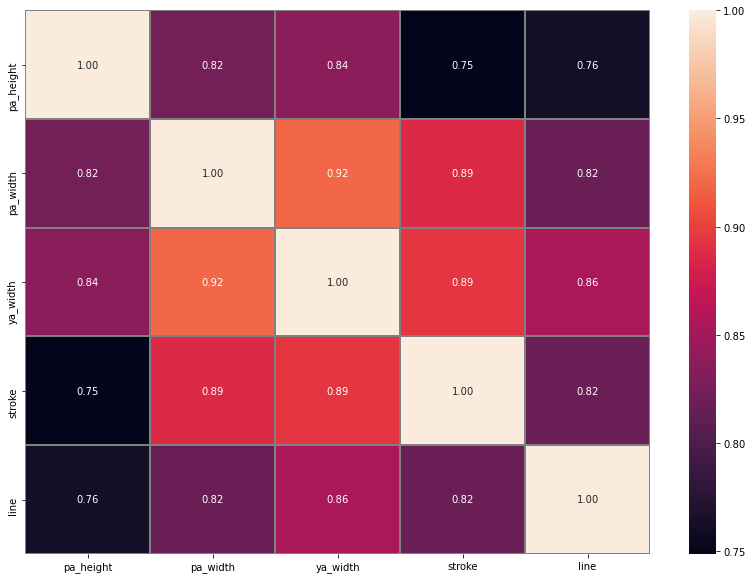

In [5]:
#сделаем выборку для рассчета коэффициента Пирсона

factor = df[['pa_height', 'pa_width','ya_width', 'stroke','line']]

# выведем матрицу корреляций Пирсона как тепловую карту

cm = factor.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot = True, fmt = '.2f', linewidths=1, linecolor='gray')
plt.show()

Согласно коэффициенту корреляции Пирсона, у нас наблюдается сильная корреляция всех наблюдаемых величин. Особенно сильная корреляция (0,92) между шириной узкой акшары и широкой акшары. Столь же явная корреляция (0,89) между толщиной линии и шириной узкой и широкой акшар. Возможно утверждать об общепринятых правилах написания акшар.

Для проверки, построим ту же тепловую карту, но по Таблице №2

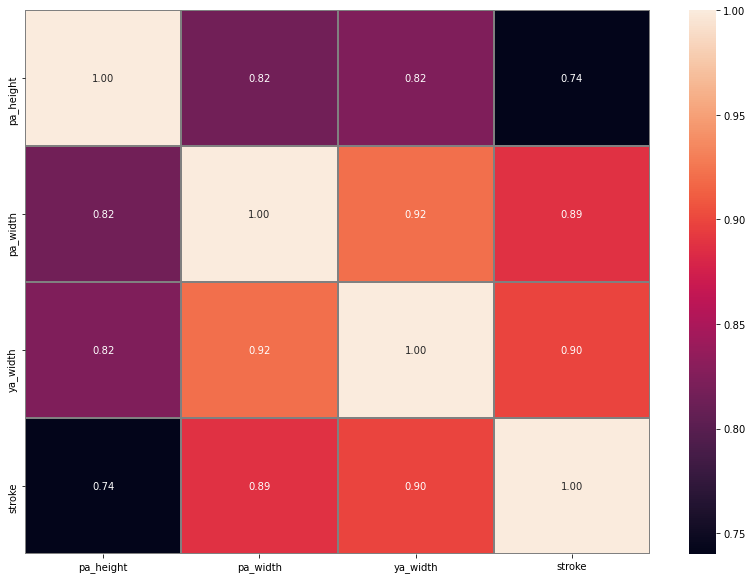

In [6]:
#сделаем выборку для рассчета коэффициента Пирсона

factor_prop = df_prop[['pa_height', 'pa_width','ya_width', 'stroke']]

# выведем матрицу корреляций Пирсона как тепловую карту

cm_prop = factor_prop.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(cm_prop, annot = True, fmt = '.2f', linewidths=1, linecolor='gray')
plt.show()

Замеченная ранее положительная корреляция только усилилась. Можно утверждать о том, что акшары старались писать максимально по правилам

Посмотрим матрицу рассеяния, построив попарно диаграммы рассеяния всех факторов, а затем укрупненно гистаграммы каждого из факторов

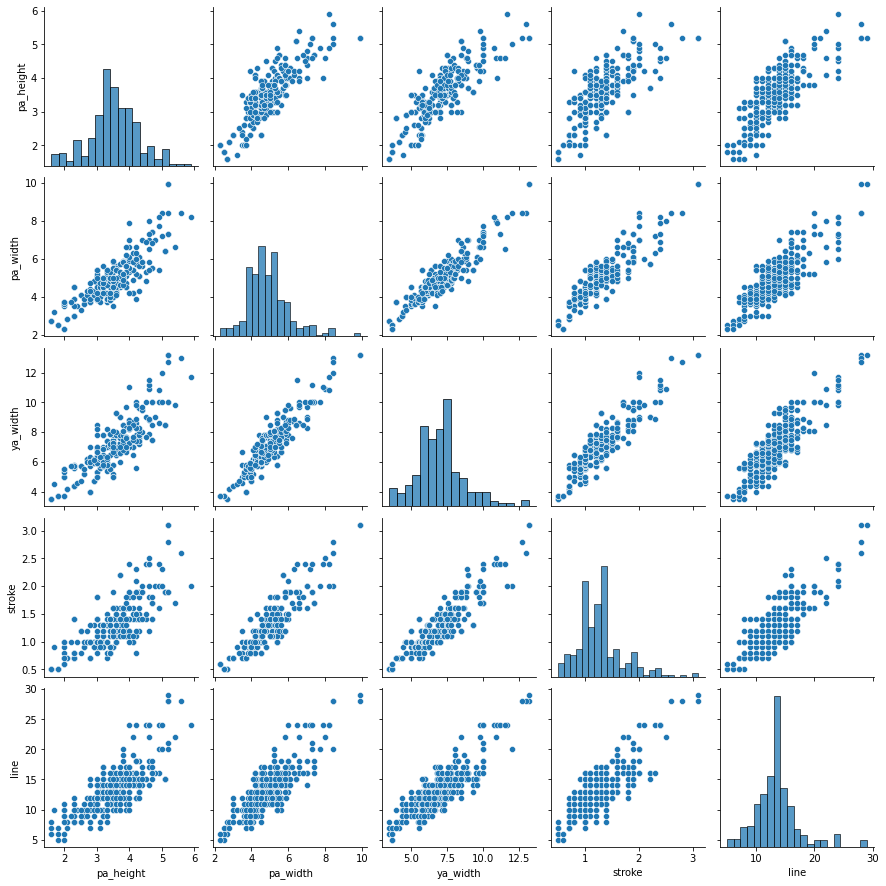

In [7]:
sns.pairplot(factor)

Распределения по виду нормальные и очевидна положительная корреляция всех рассматриваемых признаков фрагментов. При этом есть единичные выбросы, скорее всего характерные для конкретной рукописи

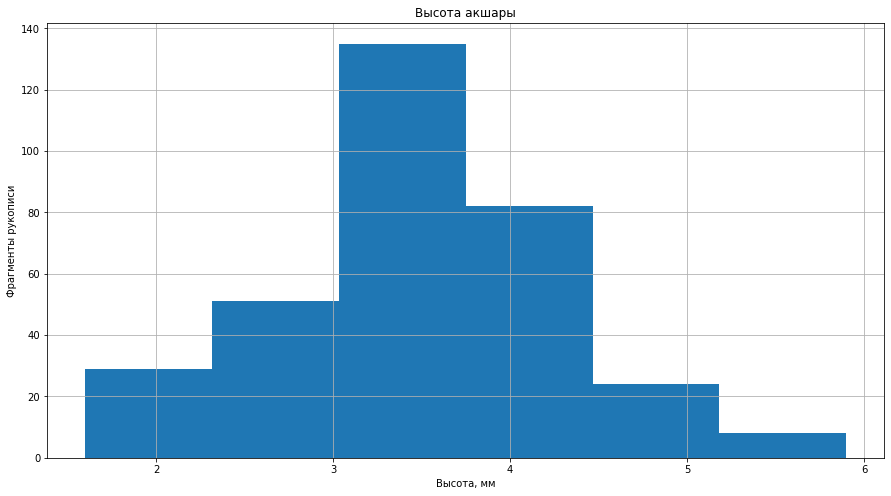

In [8]:
df['pa_height'].hist(bins=6)
plt.title('Высота акшары')
plt.ylabel('Фрагменты рукописи')
plt.xlabel('Высота, мм')
plt.show()

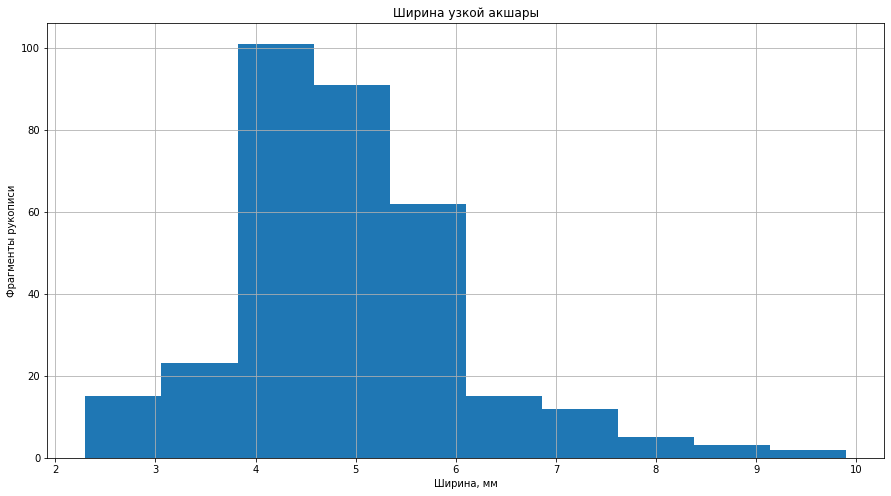

In [9]:
df['pa_width'].hist(bins=10)
plt.title('Ширина узкой акшары')
plt.ylabel('Фрагменты рукописи')
plt.xlabel('Ширина, мм')
plt.show()

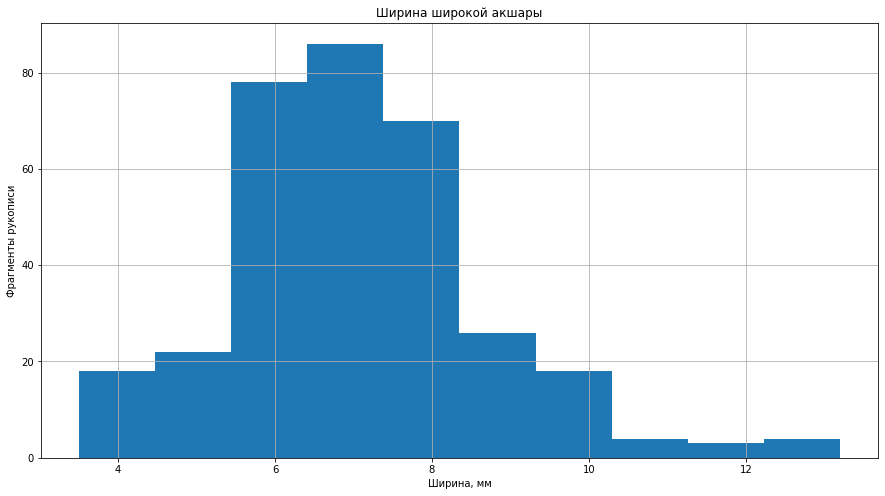

In [10]:
df['ya_width'].hist(bins=10)
plt.title('Ширина широкой акшары')
plt.ylabel('Фрагменты рукописи')
plt.xlabel('Ширина, мм')
plt.show()

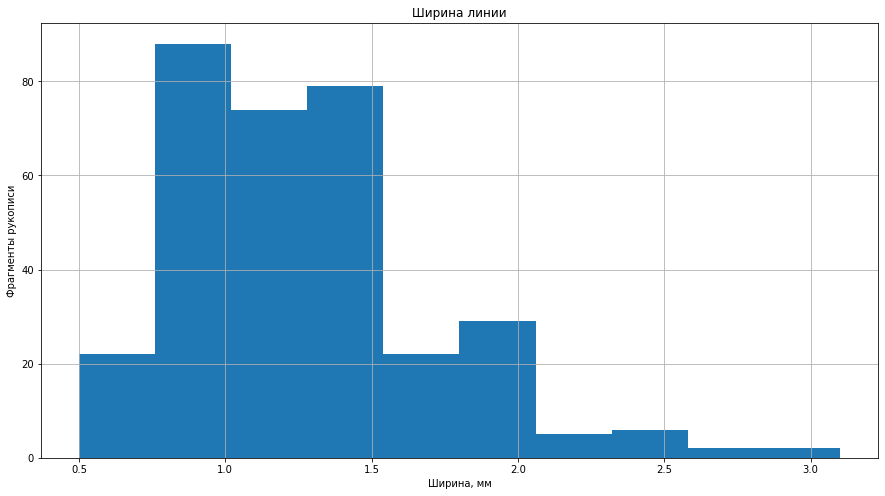

In [11]:
df['stroke'].hist(bins=10)
plt.title('Ширина линии')
plt.ylabel('Фрагменты рукописи')
plt.xlabel('Ширина, мм')
plt.show()

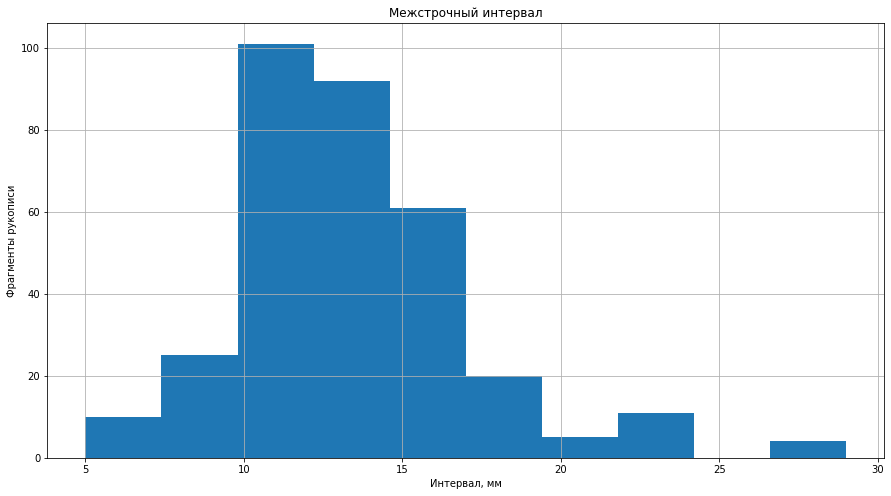

In [12]:
df['line'].hist(bins=10)
plt.title('Межстрочный интервал')
plt.ylabel('Фрагменты рукописи')
plt.xlabel('Интервал, мм')
plt.show()

In [13]:
#проверим стандартные отклонения
factor.describe().T

,count,mean,std,min,25%,50%,75%,max
pa_height,329.00,3.52,0.75,1.60,3.10,3.50,3.90,5.90
pa_width,329.00,4.92,1.15,2.30,4.20,4.80,5.40,9.90
ya_width,329.00,7.05,1.67,3.50,5.90,7.00,7.80,13.20
stroke,329.00,1.28,0.42,0.50,1.00,1.20,1.40,3.10
line,329.00,13.39,3.73,5.00,11.00,13.00,15.00,29.00


Можно сказать, что по всем показателям у нас предположительно нормальное распределение. В целом стандартное отклонение для всех показателей кроме ширины межстрочного интервала небольшое.

## Разделение фрагментов на кластеры <a class="anchor" id="3"></a>

Проведем кластеризацию для выделения характерных сегментов фрагментов. Для этого стандартизируем признаки, построим матрицу расстояний и нарисуем дендрограмму

In [14]:
#выделим список столбцов
factor_columns_list = factor.columns

# проведем обязательную стандартизацию данных перед работой с алгоритмами и подготовим матрицу признаков
sc1 = StandardScaler()
factor_sign_sс = sc1.fit_transform(factor)
factor_sign_sс = pd.DataFrame(factor_sign_sс, columns = factor_columns_list).astype('float64')

In [15]:
# построим матрицу расстояний функцией linkage на стандартизированной матрице признаков
linked = linkage(factor_sign_sс, method = 'ward')

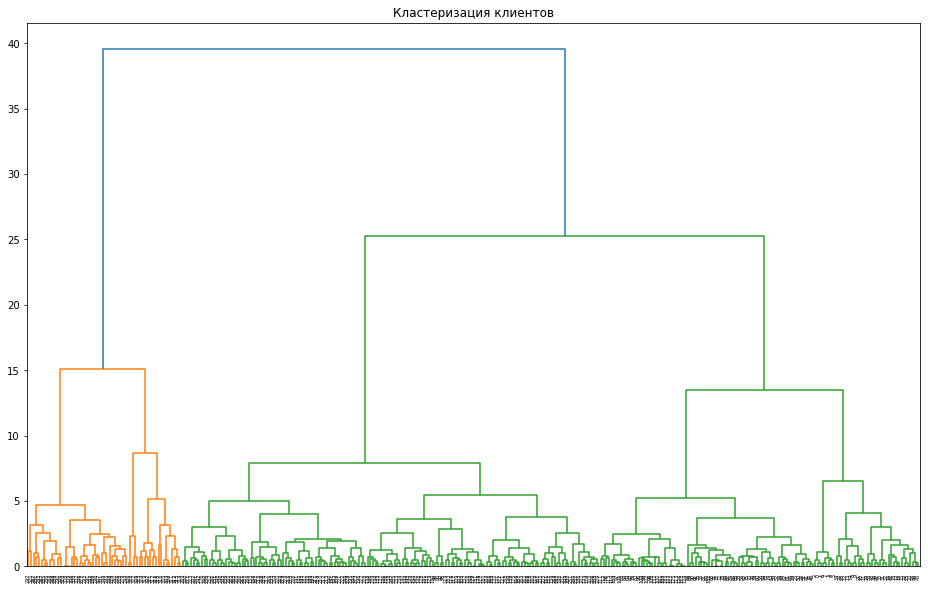

In [16]:
#построим дендрограмму
plt.figure(figsize=(16, 10))  
dendrogram(linked, orientation = 'top')
plt.title('Кластеризация клиентов')
plt.show()

Дендрограмма распределяется на примерно 5 кластеров. При это четко видно, что эти пять кластеров можно свести к трём основным. Сделаем это и обучим модель кластеризации на основании алгоритма K-Means

In [17]:
# задаём число кластеров, равное 3
km = KMeans(n_clusters = 3, random_state = 42)

# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(factor_sign_sс)

# сохраним в основных данных принадлежность записи к кластеру
df['cluster'] = labels

Посмотрим, как поделились записи между кластерами

In [18]:
#проверим размеры кластеров
df.cluster.value_counts() 

0    182
1    102
2     45
Name: cluster, dtype: int64

Похоже на дендрограмму - если бы мы взяли 2 кластера, то скорее всего кластер 2 остался бы одинакового размера, а кластеры 0 и 1 слились бы. 

Посмотрим средние значения признаков для кластеров и построим графики распределения признаков для кластеров

In [19]:
#посмотрим средние значения для кластеров
df.groupby('cluster').mean().T

cluster,0,1,2
pa_height,3.67,2.76,4.61
pa_width,5.02,3.84,6.93
ya_width,7.27,5.38,9.94
stroke,1.29,0.91,2.07
line,13.74,10.13,19.40


Похоже фрагменты рукописей кластера 2 отчетливо больше по размерам, чем остальные. Возможно у трех кластеров есть также разное отношение значений друг к другу.
Построим графики распределения признаков

In [20]:
factor2 = df[['pa_height', 'pa_width','ya_width', 'stroke','line','cluster']]

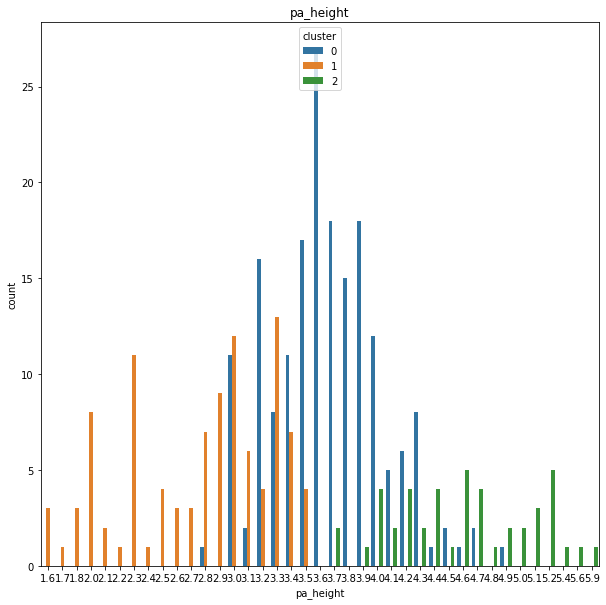

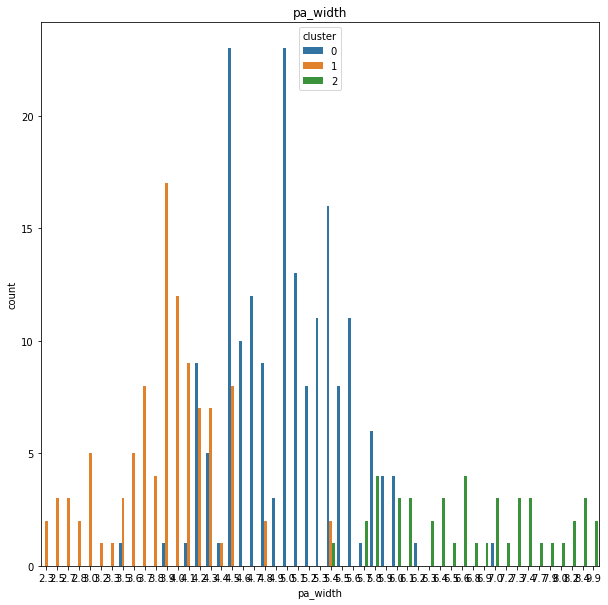

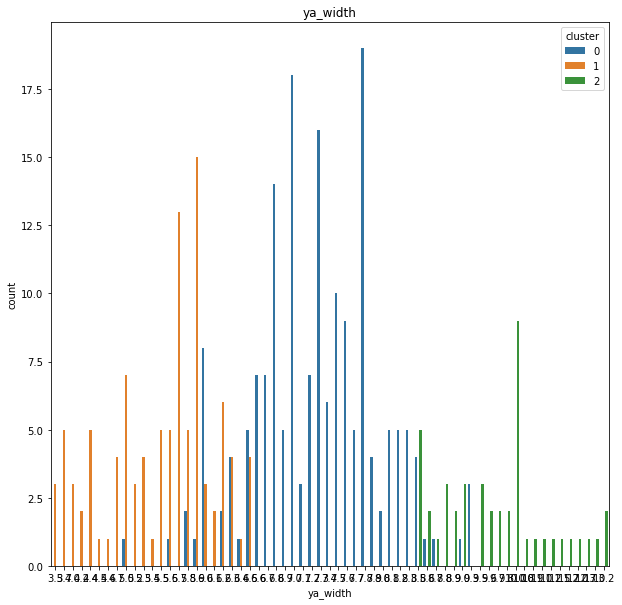

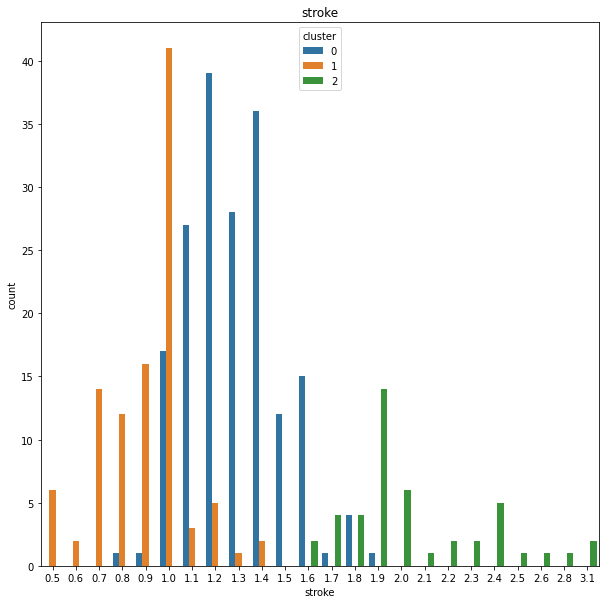

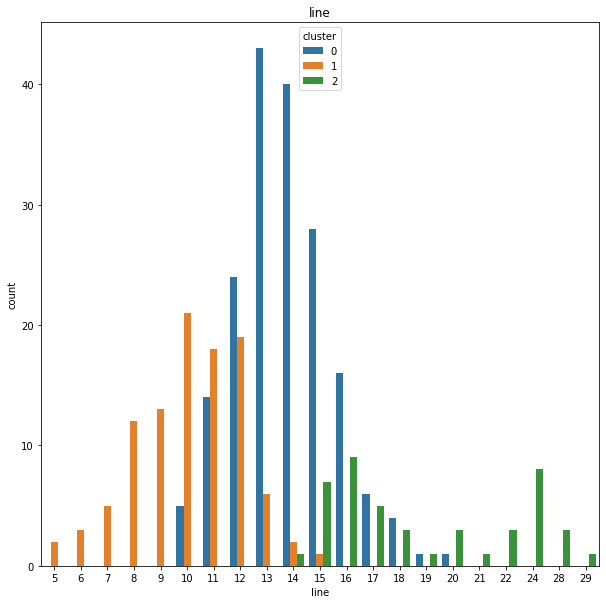

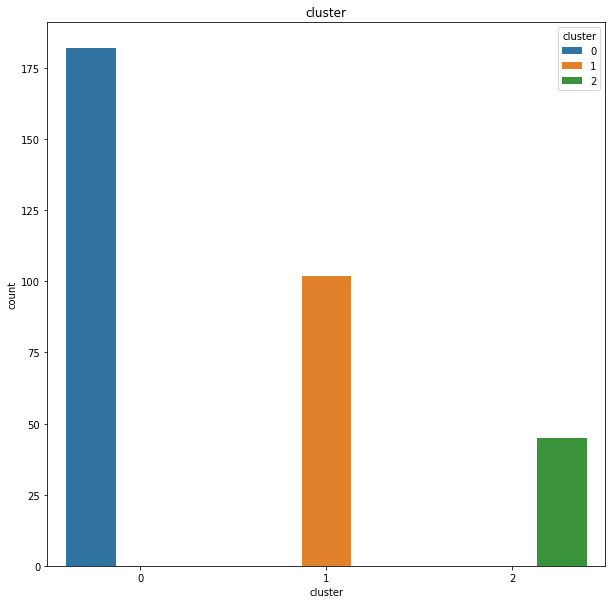

In [21]:
#построим графики распределения признаков

for column in factor2.columns: 
    plt.figure(figsize=(10, 10))
    sns.countplot(x = factor2[column], hue='cluster', data=factor2)
    plt.title(column)
    plt.show()

Очевидно большее пересечение рукописей кластеров 0 и 1. Очевидно, что рукописи кластера 2 имеет большие значения во всех показателях.

Выведем названия фрагментов рукописей кластера 2 

In [22]:
print(df[df['cluster'] ==2]['name'])

244          2991/2\1
245          2991/2\2
275              4652
276          6375/2\1
277          6375/2\2
278            2993/1
280            6379/7
281            6375/4
290            5871/3
291          2992/6\1
292          2992/6\2
293          2992/6\3
295           2945/16
296            2991/3
297            2089/1
299            2997/2
300           2917/29
301            2997/4
302            2994/8
303          2991/8\1
304          2991/8\2
305          2991/8\3
306            2985/4
307           6381/11
308            4653/1
309            4653/2
310            4653/3
311            6380/8
312            6382/1
313          6380/4\1
314          6380/4\2
315            2985/2
316            2993/5
317            2962/3
318      4638/(terms)
319      4661/(terms)
320            2998/9
321    2984/(1+2+3+4)
322    2926/(1+2+3+4)
323            2962/2
324            2998/8
325          6373/1\1
326          6373/1\2
327            6374/2
328           6381/15
Name: name

Учитывая те фрагменты, что имели разный межстрочный интервал, у нас всего 35 фрагментов рукописей в кластере 2

## Проверка гипотез <a class="anchor" id="4"></a>

Проверим гипотезы выдвинутые исследователями:
  - Есть четкие зависимости между шириной акшары и высотой, предположительно их одна-две
  - Ширина линии в 10 раз меньше межстрочного интервала
   
Сделаем промежуточные расчеты. Подсчитаем и выведем на экран различные виды отношения ширины узкой акшары к высоте.
Расчеты делаем на Таблице №2

In [23]:
df_prop['pa_pa_proportion'] = (df_prop['pa_width'] / df_prop['pa_height']).round(1)
df_prop['pa_pa_proportion'].value_counts()

1.40    49
1.30    37
1.50    32
1.20    30
1.60    22
1.70    15
1.80     8
1.10     6
1.00     4
2.00     2
1.90     2
0.90     1
Name: pa_pa_proportion, dtype: int64

Выведем для дальнейшего анализа необычные соотношения

In [24]:
print('pa_pa_proportion = 1,9')
print(df_prop[df_prop['pa_pa_proportion'] ==1.90]['name'])
print('pa_pa_proportion = 2,0')
print(df_prop[df_prop['pa_pa_proportion'] ==2.00]['name'])
print('pa_pa_proportion = 0,9')
print(df_prop[df_prop['pa_pa_proportion'] ==0.90]['name'])

pa_pa_proportion = 1,9
6        4658
205    6373/1
Name: name, dtype: object
pa_pa_proportion = 2,0
15             6382/3
201    2984/(1+2+3+4)
Name: name, dtype: object
pa_pa_proportion = 0,9
46    4642 !!
Name: name, dtype: object


Подсчитаем и выведем на экран различные виды отношения ширины широкой акшары к высоте.

In [25]:
df_prop['pa_ya_proportion'] = (df_prop['ya_width'] / df_prop['pa_height']).round(1)
df_prop['pa_ya_proportion'].value_counts()

1.90    33
1.80    32
2.10    30
2.00    27
2.20    26
1.70    15
2.50     9
2.40     8
2.30     8
1.60     6
2.60     5
2.80     3
1.40     3
2.70     1
1.30     1
1.50     1
Name: pa_ya_proportion, dtype: int64

Выведем для дальнейшего анализа необычные соотношения

In [26]:
print('pa_ya_proportion = 1,3')
print(df_prop[df_prop['pa_ya_proportion'] ==1.30]['name'])
print('pa_ya_proportion = 2,7')
print(df_prop[df_prop['pa_ya_proportion'] ==2.70]['name'])
print('pa_ya_proportion = 1,5')
print(df_prop[df_prop['pa_ya_proportion'] ==1.50]['name'])

pa_ya_proportion = 1,3
46    4642 !!
Name: name, dtype: object
pa_ya_proportion = 2,7
90    2947/2
Name: name, dtype: object
pa_ya_proportion = 1,5
20    6381/2
Name: name, dtype: object


Посмотрим как распределяются наши зависимости, проверим гипотезу о том, что есть зависимость между высотой и шириной акшар. Построим тепловую карту 

pa_ya_proportion,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,All
pa_pa_proportion,,,,,,,,,,,,,,,,,
0.9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1.0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,0,0,4
1.1,0,0,0,0,3,1,1,1,0,0,0,0,0,0,0,0,6
1.2,0,0,1,5,4,10,7,1,1,1,0,0,0,0,0,0,30
1.3,0,3,0,0,6,11,8,5,3,1,0,0,0,0,0,0,37
1.4,0,0,0,1,0,8,7,15,11,4,2,0,1,0,0,0,49
1.5,0,0,0,0,0,0,5,4,7,9,3,2,1,1,0,0,32
1.6,0,0,0,0,0,1,4,1,5,6,1,3,1,0,0,0,22
1.7,0,0,0,0,0,0,0,0,1,5,2,3,2,1,0,1,15


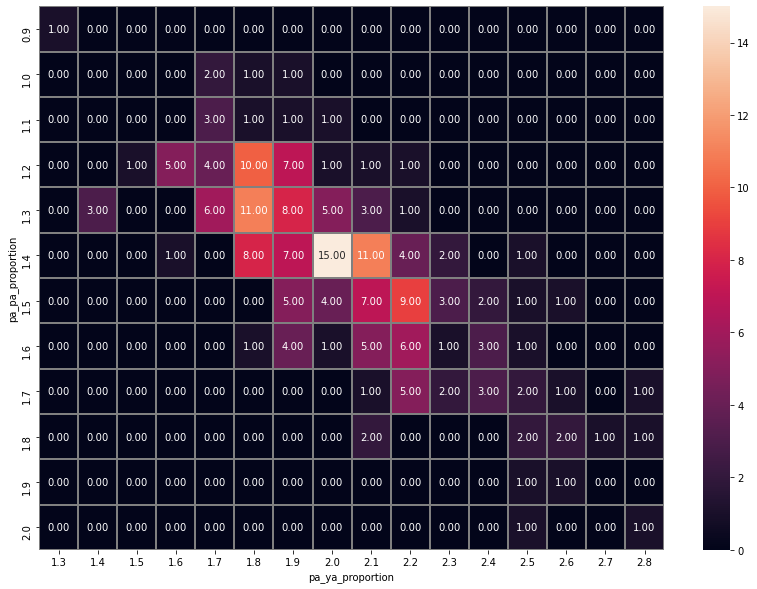

In [27]:

display(pd.crosstab(df_prop['pa_pa_proportion'], df_prop['pa_ya_proportion'], margins=True))

x= pd.crosstab(df_prop['pa_pa_proportion'], df_prop['pa_ya_proportion'])
plt.figure(figsize=(14, 10))
sns.heatmap(x, annot = True, fmt = '.2f', linewidths=1, linecolor='gray')
plt.show()

Можно подтвердить гипотезу исследователей о наличии четкой зависимости между высотой написания акшары к её ширине. Очевидно существует две-три четких школы:
1. отношение высоты к ширине широкой акшары - 2, отношение высоты к ширине узкой акшары 1,4
2. отношение высоты к ширине широкой акшары - 1,8, отношение высоты к ширине узкой акшары 1,3
Возможно есть третья тенденция
- отношение высоты к ширине широкой акшары - 2,2, отношение высоты к ширине узкой акшары 1,5 - но таких фрагментов меньше.

Проверим зависимости ширины линии от ширины широкой акшары. Расчеты делаем на Таблице №1

In [28]:
df['ya_line_proportion'] = (df['line'] / df['ya_width']).round(1)
df['ya_line_proportion'].value_counts()

1.80    50
1.90    43
1.70    40
2.00    39
2.20    32
1.60    30
2.10    30
1.50    16
2.30    14
1.40    13
2.40     9
2.50     8
2.60     3
2.70     1
1.20     1
Name: ya_line_proportion, dtype: int64

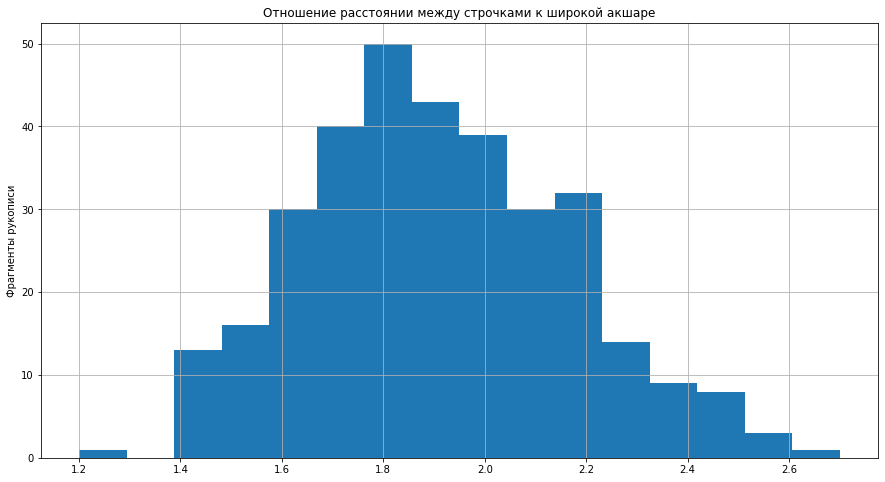

In [29]:
df['ya_line_proportion'].hist(bins=16)
plt.title('Отношение расстоянии между строчками к широкой акшаре')
plt.ylabel('Фрагменты рукописи')
plt.show()

Явно тяготение к отношению 1,8. Точнее, учитывая, погрешности замера, я бы сказал, что диапазон отношений 1,7-2,0 описывает большую часть фрагментов 

Проверим зависимости ширины линии от ширины межстрочного интервала. Расчеты делаем на Таблице №1

In [30]:
df['stroke_line_proportion'] = (df['line'] / df['stroke']).round(0)
df['stroke_line_proportion'].value_counts()

11.00    59
12.00    57
10.00    54
9.00     53
8.00     33
14.00    22
13.00    22
15.00    10
7.00      9
16.00     6
17.00     2
6.00      2
Name: stroke_line_proportion, dtype: int64

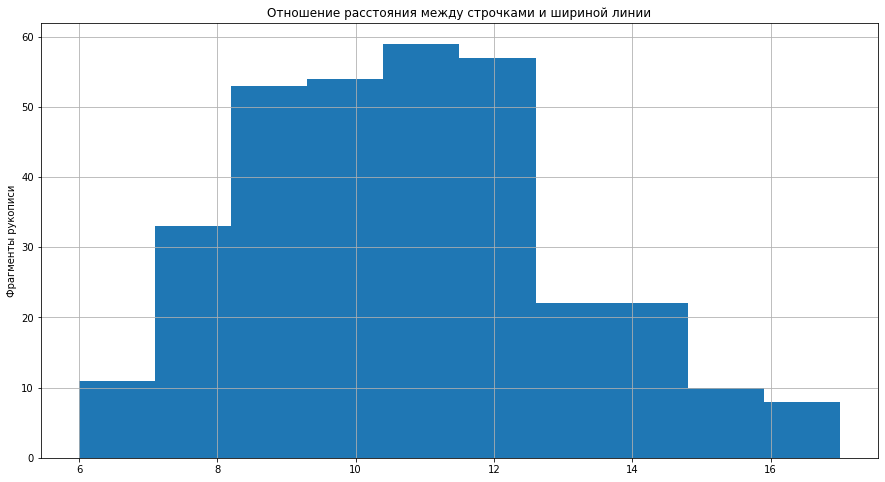

In [31]:
df['stroke_line_proportion'].hist(bins=10)
plt.title('Отношение расстояния между строчками и шириной линии')
plt.ylabel('Фрагменты рукописи')
plt.show()

Очевидный диапазон отношений 9-12. Можно подтвердить гипотезу выдвинутую исследователями о том, что как правило ширина линии в 10 раз меньше межстрочного интервала

In [32]:
# выгрузим данные для дальнейшего анализа необычных фрагментов рукописей
df.to_csv('table_1.csv', index=False)
df_prop.to_csv('table_2.csv', index=False)
df.to_excel("table_1_excel.xlsx", index=False)
df_prop.to_excel("table_2_excel.xlsx", index=False)

## Выводы <a class="anchor" id="5"></a>

Согласно коэффициенту корреляции Пирсона, у нас наблюдается сильная корреляция всех наблюдаемых величин. Особенно сильная корреляция (0,92) между шириной узкой акшары и широкой акшары. Столь же явная корреляция (0,89) между толщиной линии и шириной узкой и широкой акшар. Возможно утверждать об общепринятых правилах написания акшар.

Можно подтвердить гипотезу исследователей о наличии четкой зависимости между высотой написания акшары к её ширине. Очевидно существует две-три четких школы:
1. отношение высоты к ширине широкой акшары - 2, отношение высоты к ширине узкой акшары 1,4
2. отношение высоты к ширине широкой акшары - 1,8, отношение высоты к ширине узкой акшары 1,3
Возможно есть третья тенденция
- отношение высоты к ширине широкой акшары - 2,2, отношение высоты к ширине узкой акшары 1,5 - но таких фрагментов меньше.

Очевидный диапазон отношений расстояния между строчками и шириной линии 9-12. Можно подтвердить гипотезу выдвинутую исследователями о том, что как правило ширина линии в 10 раз меньше межстрочного интервала